In [1]:
import matplotlib as mpl
import mplscience
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

import seml

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
results = seml.get_results("moscot_map", to_data_frame=True)

  0%|          | 0/624 [00:00<?, ?it/s]

  0%|          | 0/624 [00:00<?, ?it/s]

In [3]:
results.columns

Index(['_id', 'config.overwrite', 'config.db_collection', 'config.dataset',
       'config.method', 'config.params.alpha', 'config.params.epsilon',
       'config.path_data', 'config.path_results', 'config.seed', 'result.time',
       'result.method', 'result.method_info.converged',
       'result.method_info.cost', 'result.adata_sc_size',
       'result.adata_sp_size', 'result.gene_size', 'result.corr_results_mean',
       'result.corr_results_median', 'result.corr_results_var',
       'result.corr_results_max', 'result.corr_results_min',
       'config.params.learning_rate', 'config.params.num_epochs',
       'result.method_info.kl_reg', 'config.params.epochs',
       'config.params.n_latent', 'result.method_info'],
      dtype='object')

In [4]:
results.shape

(624, 28)

In [5]:
len(results["config.seed"].unique()) > 1

True

## Process results and plot

In [6]:
columns = [
    "config.dataset",
    "config.params.alpha",
    "config.params.epsilon",
    "result.method",
    "config.params.learning_rate",
    "config.params.num_epochs",
    "config.params.epochs",
    "config.params.n_latent",
]
results["unique_config"] = results[columns].apply(
    lambda x: "".join(str(x)).replace(" ", ""), axis=1, raw=True
)

In [7]:
results["corrvalue"] = [pd.Series(["pearson", "spearman"]) for i in range(len(results))]
results["size"] = results["result.adata_sp_size"] + results["result.adata_sc_size"]
cols = [
    "config.dataset",
    "result.time",
    "result.method",
    "result.adata_sc_size",
    "result.adata_sp_size",
    "result.gene_size",
    "result.corr_results_mean",
    "result.corr_results_median",
    "result.corr_results_var",
    "result.corr_results_max",
    "result.corr_results_min",
    "config.seed",
    "unique_config",
    "size",
    "corrvalue",
]
rename_cols = [
    "dataset",
    "time",
    "method",
    "adata_sc_size",
    "adata_sp_size",
    "gene_size",
    "mean_corr",
    "median_corr",
    "var_corr",
    "max_corr",
    "min_corr",
    "seed",
    "unique_config",
    "size",
    "corrvalue",
]
cols_explode = [
    "result.corr_results_mean",
    "result.corr_results_median",
    "result.corr_results_var",
    "result.corr_results_max",
    "result.corr_results_min",
    "corrvalue",
]
results = results.explode(cols_explode)
final_df = results[cols].rename(columns={k: v for k, v in zip(cols, rename_cols)})

In [8]:
best_config = []
for d in final_df.dataset.unique():
    for m in final_df.method.unique():
        cond = (
            (final_df.method == m)
            & (final_df.dataset == d)
            & (final_df.corrvalue == "spearman")
        )
        temp_df = final_df[cond].copy()
        if len(temp_df["seed"].unique()) > 1:
            conf = (
                temp_df[["unique_config", "median_corr", "seed"]]
                .groupby(["unique_config", "seed"])
                .median()
                .reset_index()
                .sort_values(by="median_corr", ascending=False)
                .reset_index(drop=True)
                .unique_config[0]
            )
            best_config.append(temp_df[temp_df.unique_config == conf].copy())

In [9]:
plot_df = pd.concat(best_config)
plot_df["method"] = pd.Categorical(
    plot_df["method"], categories=["MOSCOT", "TANGRAM", "GIMVI"]
)
plot_df = plot_df.drop_duplicates()
plot_df["method"] = plot_df["method"].replace(
    {"MOSCOT": "moscot", "GIMVI": "gimVI", "TANGRAM": "Tangram"}
)

In [10]:
plot_df[(plot_df.method == "moscot") & (plot_df.dataset == 14)]

,dataset,time,method,adata_sc_size,adata_sp_size,gene_size,mean_corr,median_corr,var_corr,max_corr,min_corr,seed,unique_config,size,corrvalue
129,14,5.826542,moscot,1519,1520,10,0.76341,0.75374,0.009431,0.884836,0.620564,42,[140.10.005'MOSCOT'nannannannan],3039,spearman
135,14,6.091364,moscot,1519,1520,10,0.766142,0.811012,0.01343,0.909644,0.553353,224,[140.10.005'MOSCOT'nannannannan],3039,spearman
141,14,6.116506,moscot,1519,1520,10,0.786428,0.788978,0.007739,0.882993,0.617817,422,[140.10.005'MOSCOT'nannannannan],3039,spearman


In [11]:
plot_df.dataset.unique()

array([30, 37, 45, 26, 22, 33, 32, 14,  3, 20, 21, 41,  1, 39])

In [12]:
# plot_df["binned"] = pd.cut(
#     plot_df["size"],
#     bins=4,
#     # labels=[
#     #     "~2000<size<~4000",
#     #     "~4000<size<~6000",
#     #     "~6000<size<~8000",
#     #     "~8000<size<~10_000",
#     # ],
# )
# plot_df["binned"].value_counts()

In [13]:
# labs = [
#     "~2000<size<~4000",
#     "~4000<size<~6000",
#     "~6000<size<~8000",
#     "~8000<size<~10_000",
# ]
# plot_df["binned"] = pd.cut(
#     plot_df["size"],
#     bins=4,
#     labels=labs,
# )
# plot_df["binned"].value_counts()
# plot_df["binned"] = pd.Categorical(plot_df["binned"], categories=labs)

In [14]:
plot_df

,dataset,time,method,adata_sc_size,adata_sp_size,gene_size,mean_corr,median_corr,var_corr,max_corr,min_corr,seed,unique_config,size,corrvalue
0,30,5.952272,moscot,1032,1032,100,0.198771,0.149353,0.032047,0.715172,-0.051302,42,[300.10.01'MOSCOT'nannannannan],2064,spearman
6,30,4.893740,moscot,1032,1032,100,0.247374,0.184145,0.04639,0.899399,-0.03153,224,[300.10.01'MOSCOT'nannannannan],2064,spearman
12,30,5.375905,moscot,1032,1032,100,0.248538,0.193561,0.042643,0.801065,-0.046182,422,[300.10.01'MOSCOT'nannannannan],2064,spearman
390,30,33.709328,gimVI,1032,1032,100,-0.009504,-0.003136,0.002127,0.074319,-0.130438,42,[30nannan'GIMVI'nannan200.010.0],2064,spearman
396,30,35.631883,gimVI,1032,1032,100,0.000401,0.00375,0.001724,0.094788,-0.108339,224,[30nannan'GIMVI'nannan200.010.0],2064,spearman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,39,8.533029,Tangram,4926,4926,100,0.091971,0.052963,0.012739,0.486971,-0.022024,42,[39nannan'TANGRAM'0.1500.0nannan],9852,spearman
384,39,5.115616,Tangram,4926,4926,100,0.107087,0.069895,0.012014,0.445652,-0.025824,224,[39nannan'TANGRAM'0.1500.0nannan],9852,spearman
610,39,341.503433,gimVI,4926,4926,100,-0.003761,-0.009692,0.001375,0.126816,-0.088433,42,[39nannan'GIMVI'nannan600.010.0],9852,spearman
616,39,503.404080,gimVI,4926,4926,100,-0.001583,-0.006423,0.001743,0.141081,-0.093197,224,[39nannan'GIMVI'nannan600.010.0],9852,spearman


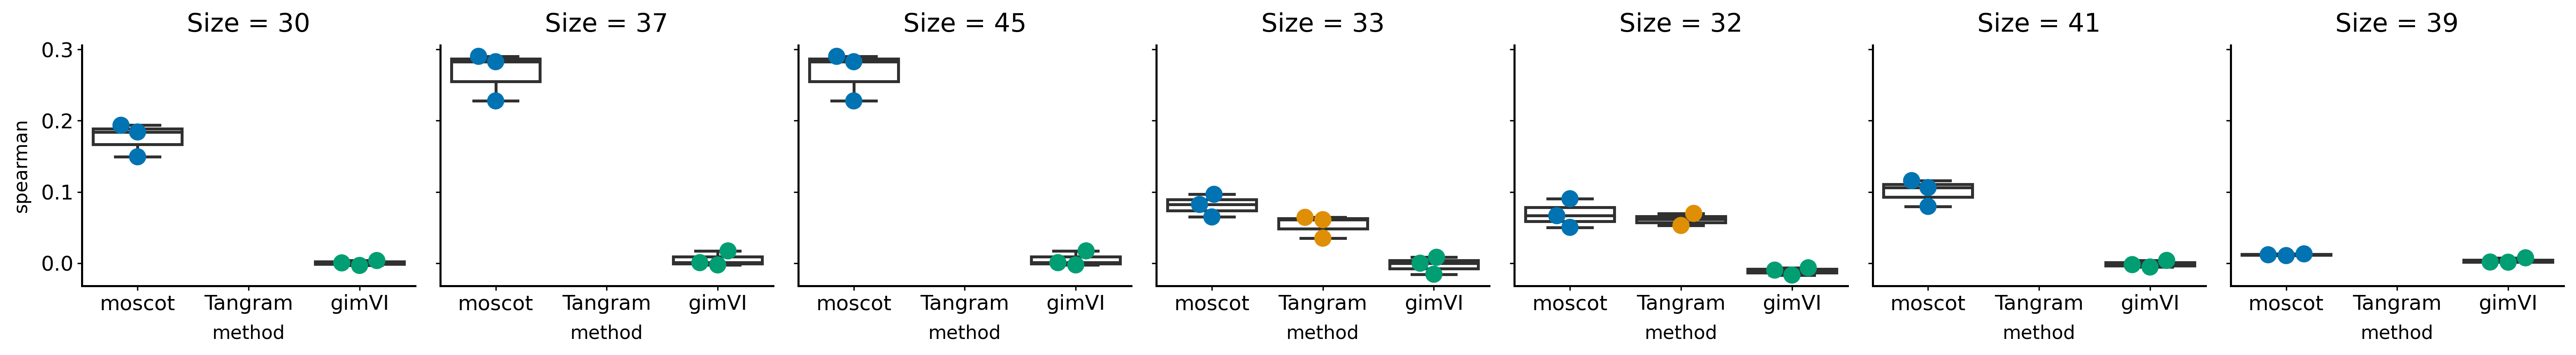

In [18]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
cond = plot_df.dataset > 29

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label],
    )
    g = sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    )


g = sns.FacetGrid(plot_df[cond], col="dataset")
g.map(
    fixed_boxplot,
    "method",
    "median_corr",
)
axes = g.axes.flatten()
for ax, siz in zip(axes, plot_df[cond]["dataset"].unique()):
    ax.set_title(f"Size = {siz}")
    ax.set_ylabel("spearman")

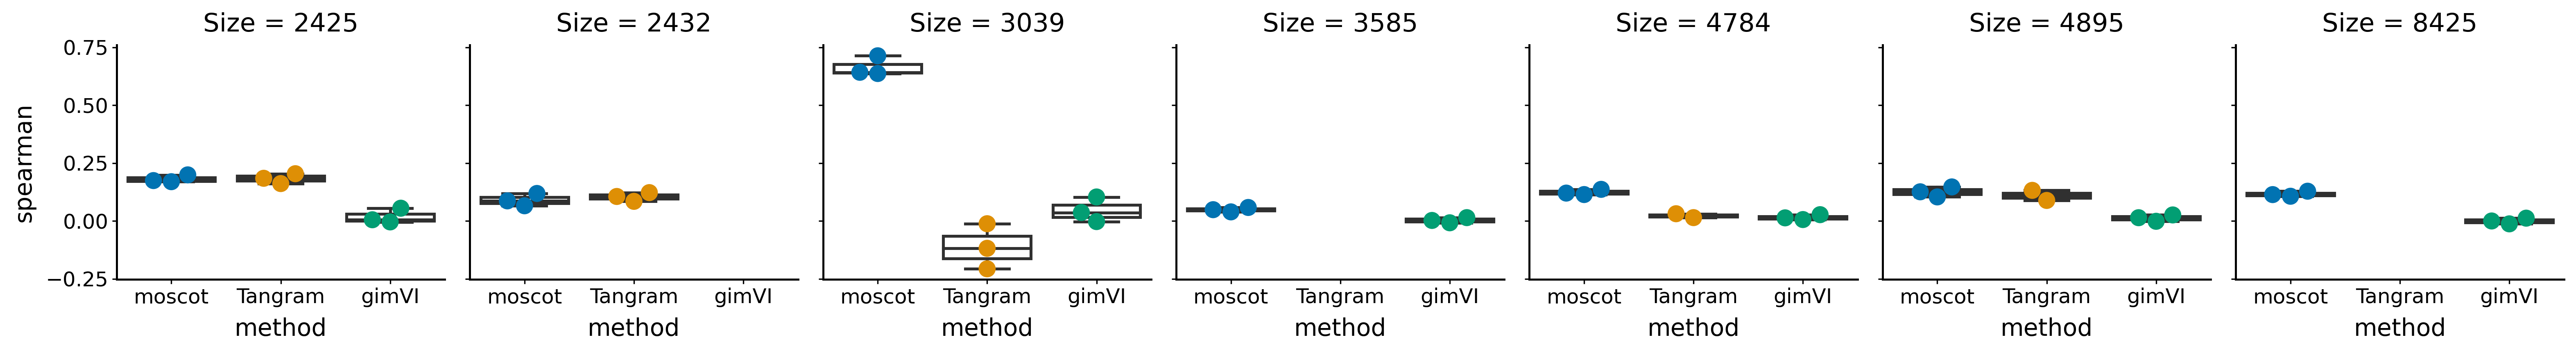

In [64]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
cond = plot_df.dataset < 29

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label],
    )
    g = sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    )


g = sns.FacetGrid(plot_df[cond], col="dataset")
g.map(
    fixed_boxplot,
    "method",
    "median_corr",
)
axes = g.axes.flatten()
for ax, siz in zip(axes, plot_df[cond]["size"].unique()):
    ax.set_title(f"Size = {siz}")
    ax.set_ylabel("spearman")

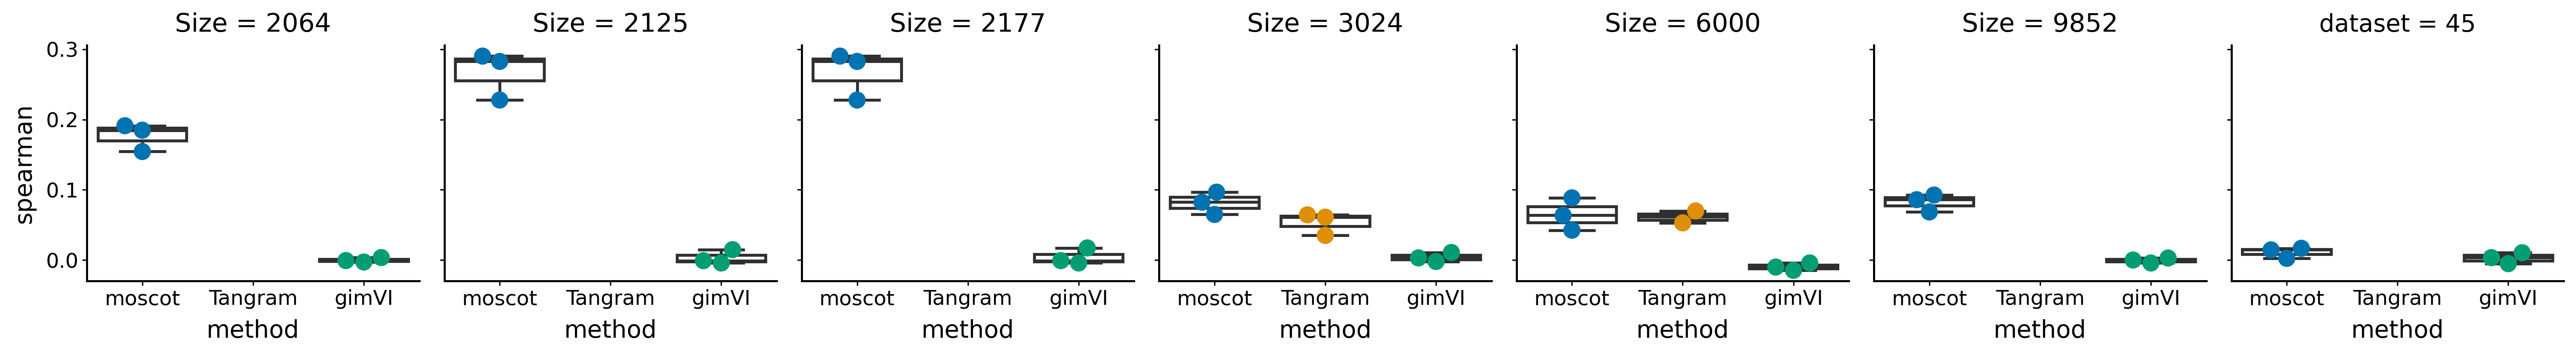

In [65]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
cond = plot_df.dataset > 29

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label],
    )
    g = sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    )


g = sns.FacetGrid(plot_df[cond], col="dataset")
g.map(
    fixed_boxplot,
    "method",
    "median_corr",
)
axes = g.axes.flatten()
for ax, siz in zip(axes, plot_df[cond]["size"].unique()):
    ax.set_title(f"Size = {siz}")
    ax.set_ylabel("spearman")

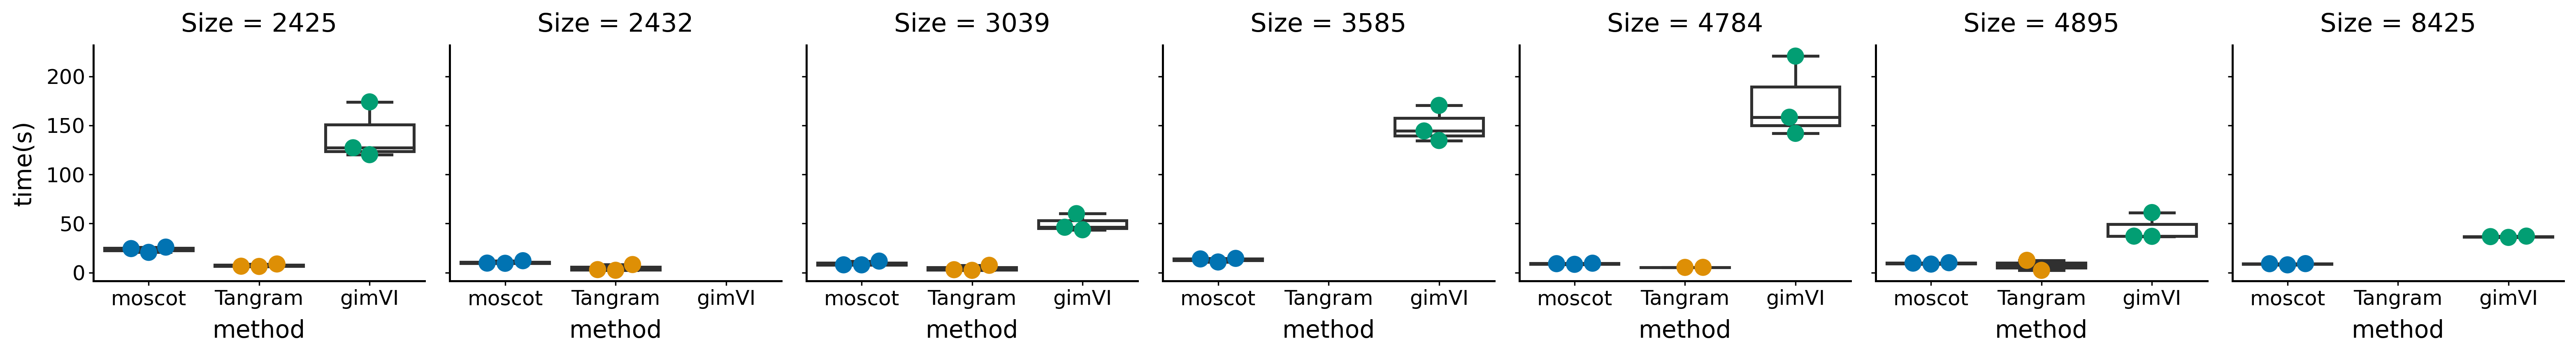

In [69]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
cond = plot_df.dataset < 29

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label],
    )
    g = sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    )


g = sns.FacetGrid(plot_df[cond], col="dataset")
g.map(
    fixed_boxplot,
    "method",
    "time",
)
axes = g.axes.flatten()
for ax, siz in zip(axes, plot_df[cond]["size"].unique()):
    ax.set_title(f"Size = {siz}")
    ax.set_ylabel("time(s)")

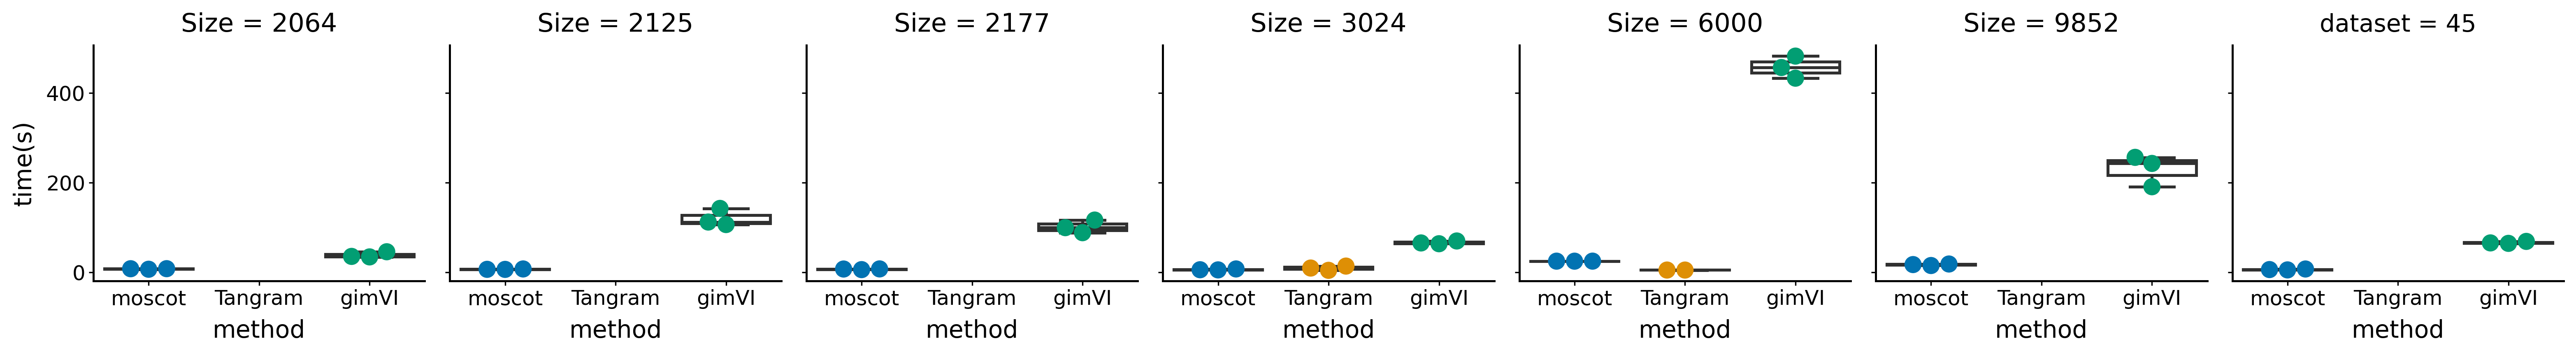

In [70]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
cond = plot_df.dataset > 29

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label],
    )
    g = sns.swarmplot(
        x=x, y=y, hue=x, palette="colorblind", size=10, dodge=False, *args, **kwargs
    )


g = sns.FacetGrid(plot_df[cond], col="dataset")
g.map(
    fixed_boxplot,
    "method",
    "time",
)
axes = g.axes.flatten()
for ax, siz in zip(axes, plot_df[cond]["size"].unique()):
    ax.set_title(f"Size = {siz}")
    ax.set_ylabel("time(s)")

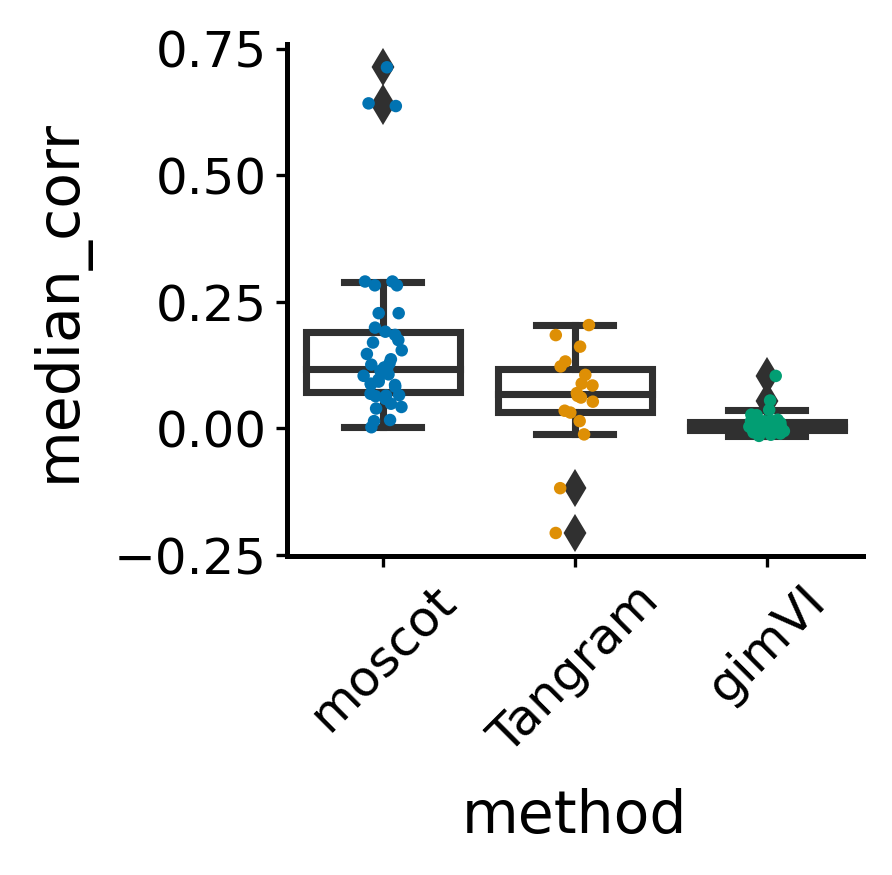

In [55]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
# palette = "deep"

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label]
    )
    sns.stripplot(x=x, y=y, hue=x, palette="colorblind", size=3, *args, **kwargs)
    plt.xticks(rotation=45)


g = sns.FacetGrid(plot_df)
g.map(fixed_boxplot, "method", "median_corr")

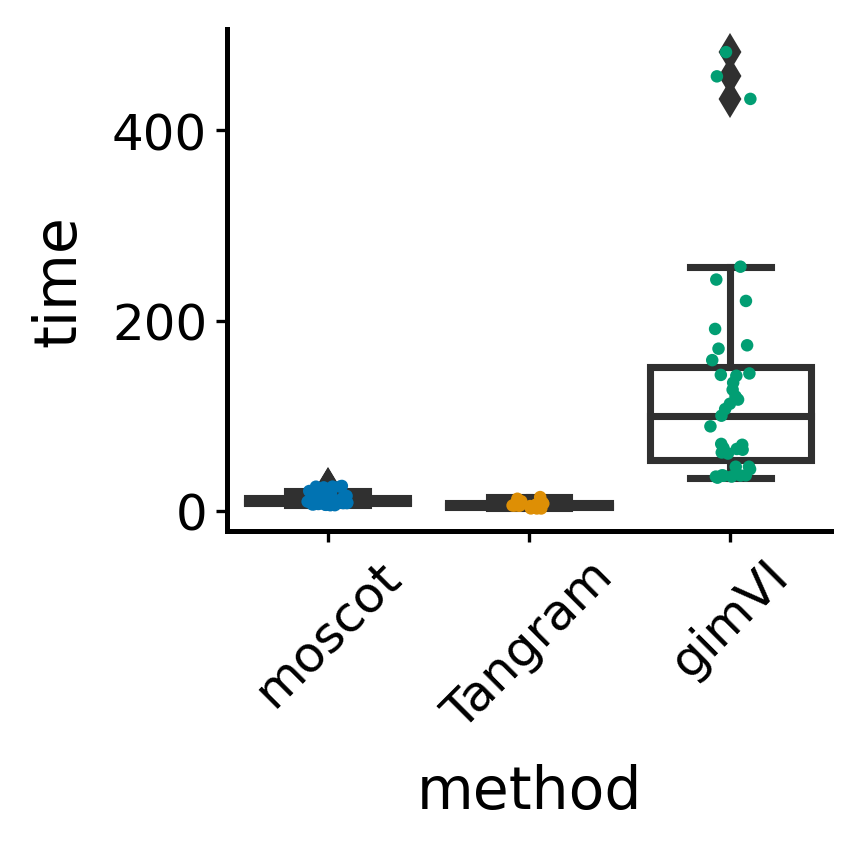

In [25]:
mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
# palette = "deep"

# sc.set_figure_params(figsize=(3, 3), dpi=100)
# fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200)


def fixed_boxplot(x, y, *args, label=None, **kwargs):
    sns.boxplot(
        x=x,
        y=y,
        hue=x,
        palette="colorblind",
        boxprops={"facecolor": "None"},
        dodge=False,
        *args,
        **kwargs,
        labels=[label]
    )
    sns.stripplot(x=x, y=y, hue=x, palette="colorblind", size=3, *args, **kwargs)
    plt.xticks(rotation=45)


g = sns.FacetGrid(plot_df)
g.map(fixed_boxplot, "method", "time")

In [72]:
plot_df[plot_df.dataset == 14]

,dataset,time,method,adata_sc_size,adata_sp_size,gene_size,mean_corr,median_corr,var_corr,max_corr,min_corr,seed,unique_config,size,corrvalue
127,14,7.935103,moscot,1519,1520,10,0.634498,0.642116,0.013679,0.803953,0.428507,42,[140.50.01'MOSCOT'nannannannan],3039,spearman
133,14,7.966042,moscot,1519,1520,10,0.623775,0.636835,0.033326,0.884777,0.335334,224,[140.50.01'MOSCOT'nannannannan],3039,spearman
139,14,11.755186,moscot,1519,1520,10,0.622275,0.713382,0.048637,0.875368,0.288523,422,[140.50.01'MOSCOT'nannannannan],3039,spearman
309,14,2.342178,Tangram,1519,1520,10,-0.115336,-0.117877,0.03373,0.223407,-0.463745,42,[14nannan'TANGRAM'0.01500.0nannan],3039,spearman
315,14,7.469149,Tangram,1519,1520,10,-0.21137,-0.206375,0.072635,0.128361,-0.64045,224,[14nannan'TANGRAM'0.01500.0nannan],3039,spearman
321,14,2.987033,Tangram,1519,1520,10,-0.078409,-0.011669,0.040154,0.131778,-0.494047,422,[14nannan'TANGRAM'0.01500.0nannan],3039,spearman
517,14,46.246774,gimVI,1519,1520,10,0.074141,-0.002487,0.031915,0.399376,-0.078419,42,[14nannan'GIMVI'nannan200.020.0],3039,spearman
523,14,60.114830,gimVI,1519,1520,10,0.143329,0.103811,0.031898,0.386569,-0.075647,224,[14nannan'GIMVI'nannan200.020.0],3039,spearman
529,14,43.682843,gimVI,1519,1520,10,0.030078,0.036713,0.047301,0.395745,-0.420065,422,[14nannan'GIMVI'nannan200.020.0],3039,spearman


## Compute and plot spatial correspondence

In [59]:
from pathlib import Path

import scanpy as sc

import moscot as mt

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
dataset = 14
adata_sp = sc.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
# adata_sc = sc.read(Path(path_data) / f"dataset{dataset}_sc.h5ad")

2023-01-18 14:34:33.304202: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-18 14:34:36.643474: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-18 14:34:36.920034: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dyn

In [60]:
mp = mt.problems.space.MappingProblem(adata_sp, adata_sp).prepare(
    sc_attr={"attr": "X"}, batch_key=None
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.X`                                                                              


In [61]:
df_out = mp.spatial_correspondence(max_dist=300)

In [62]:
df_out["value_interval"] = round(df_out["value_interval"])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '30.0'),
  Text(1, 0, '60.0'),
  Text(2, 0, '90.0'),
  Text(3, 0, '120.0'),
  Text(4, 0, '150.0'),
  Text(5, 0, '180.0'),
  Text(6, 0, '210.0'),
  Text(7, 0, '240.0'),
  Text(8, 0, '270.0'),
  Text(9, 0, '300.0')])

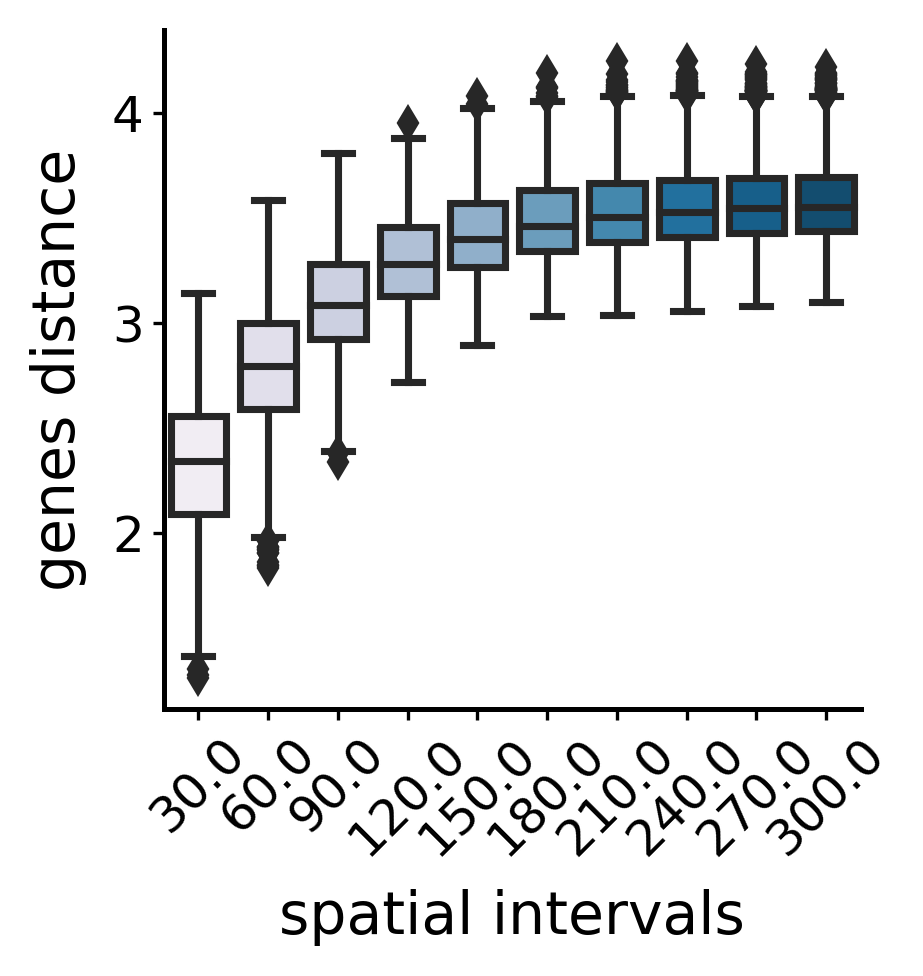

In [63]:
g = sns.boxplot(df_out, x="value_interval", y="features_distance", palette="PuBu")
g.set_ylabel("genes distance")
g.set_xlabel("spatial intervals")
plt.xticks(rotation=45)

In [61]:
plot_df.dataset.unique()

array([30, 37, 45, 26, 22, 33, 32, 14,  3, 20, 21, 41,  1, 39])

In [81]:
from scipy.spatial import ConvexHull
from scipy.stats import spearmanr

corrs = {}
for d in plot_df.dataset.unique():
    adata_sp = sc.read(Path(path_data) / f"dataset{d}_sp.h5ad")
    mp = mt.problems.space.MappingProblem(adata_sp, adata_sp).prepare(
        sc_attr={"attr": "X"},
        join_attr={"attr": "X"},
        kwargs={"xy_callback": None},
        batch_key=None,
    )
    # spatial = adata_sp.obsm["spatial"]
    # interval = 10
    # hull = ConvexHull(spatial)
    # area = hull.volume
    # max_dist = round(((area / 2) ** 0.5) / 2)
    # support = np.linspace(max_dist / interval, max_dist, interval)
    df_out = mp.spatial_correspondence()
    df_out = df_out[df_out.index_interval.isin(np.arange(5))].copy()
    corr, pval = spearmanr(df_out["features_distance"], df_out["value_interval"])
    corrs[d] = corr
    print(f"Done with dataset {d}")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.X`                                                                              
Done with dataset 30
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.X`                                                                              
Done with dataset 37
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.X`                                                                              
Done with dataset 45
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
WARNING  Densifying data in `adata.X`                                                                              
Done with

KeyError: '_i82'

In [14]:
# dataset_corr_df = pd.DataFrame(corrs, index=np.arange(len(list(corrs.keys())))).melt().rename(
#     columns={"variable": "dataset", "value": "spearman"}
# ).drop_duplicates()
# dataset_corr_df.to_csv("/home/icb/giovanni.palla/code/moscot_benchmarks/experiments/space/mapping/method_benchmark/spatial_correspondence_results.csv.gz")

## Plot spatial correspondence versus performance

In [15]:
dataset_corr_df = pd.read_csv(
    "/home/icb/giovanni.palla/code/moscot_benchmarks/experiments/space/mapping/method_benchmark/spatial_correspondence_results.csv.gz"
)

In [16]:
dataset_df = (
    plot_df[["dataset", "method", "median_corr"]]
    .groupby(["dataset", "method"])
    .median()
    .reset_index()
)
dataset_df = dataset_df.merge(dataset_corr_df, on="dataset")
dataset_df

,dataset,method,median_corr,Unnamed: 0,spearman
0,1,moscot,0.174568,168,0.222569
1,1,Tangram,0.184460,168,0.222569
2,1,gimVI,0.005422,168,0.222569
3,3,moscot,0.086966,112,0.016044
4,3,Tangram,0.105930,112,0.016044
5,3,gimVI,NaN,112,0.016044
6,14,moscot,0.642116,98,0.670703
7,14,Tangram,-0.117877,98,0.670703
8,14,gimVI,0.036713,98,0.670703
9,20,moscot,0.048917,126,0.161322


Text(0.5, 106.5, 'median spearman \nspatial correspondence')

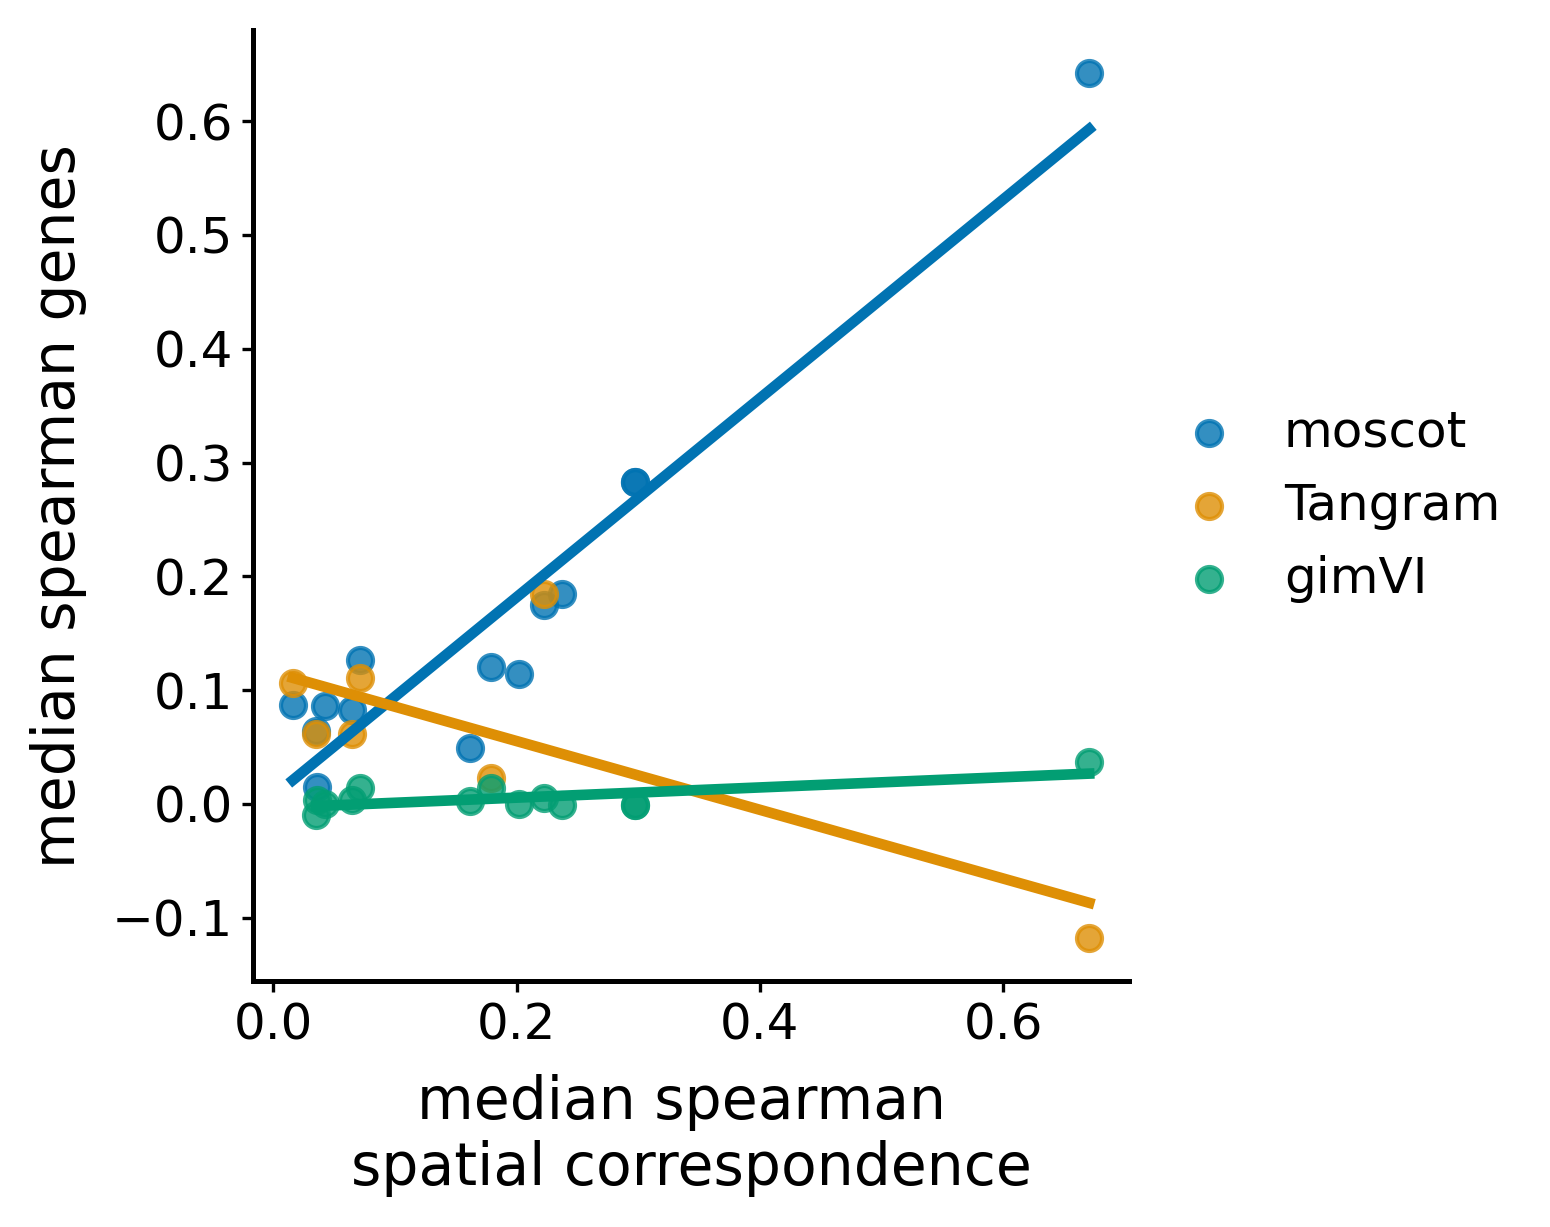

In [57]:
# mplscience.set_style()
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["legend.scatterpoints"] = 1

g = sns.lmplot(
    dataset_df,
    x="spearman",
    y="median_corr",
    hue="method",
    palette="colorblind",
    legend=False,
    ci=False,
    height=4,
    aspect=1,
)
# g = sns.scatterplot(
#     dataset_df, x="spearman", y="median_corr", hue="method", palette="colorblind", ax=g
# )
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
g.axes[0][0].set_ylabel("median spearman genes")
g.axes[0][0].set_xlabel("median spearman \nspatial correspondence")
# plt.xticks(rotation=45)